In [ ]:
!pip install prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import prince

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Clean_Dataset.csv')


Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["class"]
)

In [ ]:
# 3. Create a Subset (15,000 rows) for Memory Safety
# We use this subset for both FAMD and Clustering
df_subset = train_df.sample(n=5000, random_state=42).copy()
df_subset = df_subset.drop(columns=['Unnamed: 0', 'flight'])

# 4. SEPARATE Target (Price) from Features (X)
# We drop 'price' from X so the clustering is based purely on flight characteristics
X = df_subset.drop(columns=['price'])
y = df_subset['price']  # Kept for validation if needed

print(f"Setup Complete. Analysis will be performed on {X.shape[0]} rows and {X.shape[1]} columns (Price excluded).")

Setup Complete. Analysis will be performed on 5000 rows and 9 columns (Price excluded).


Calculating Elbow Plot...
k=1, Inertia=33263.86
k=2, Inertia=29324.60
k=3, Inertia=26748.47
k=4, Inertia=25578.79
k=5, Inertia=24539.05
k=6, Inertia=23682.92
k=7, Inertia=23083.02
k=8, Inertia=22675.17
k=9, Inertia=22227.51
k=10, Inertia=21870.07


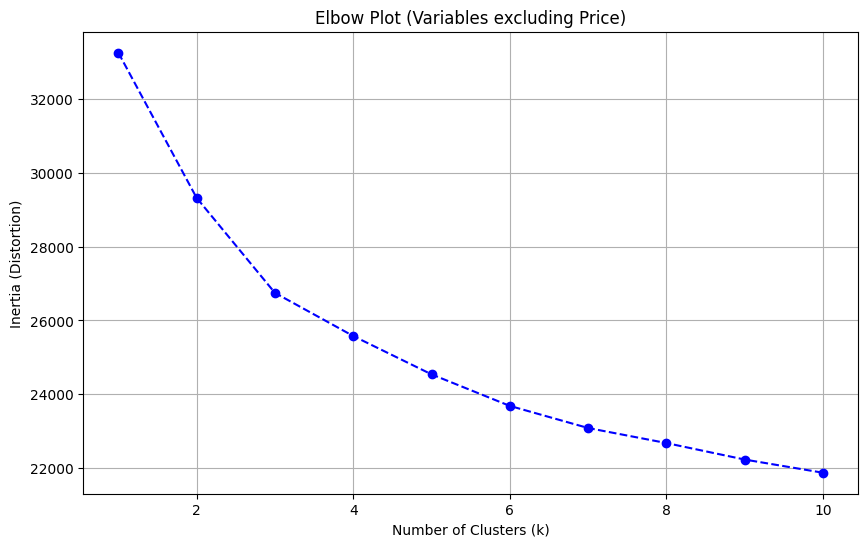

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Ensure X is defined (from Step 0). If not, run Step 0 first.
# If you have X ready, this code will run.

# 1. Preprocessing for Elbow Check
# We need to turn categorical text into numbers (One-Hot Encoding) for the Elbow check
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(sparse_output=False), categorical_cols)
    ],
    verbose_feature_names_out=False
)

X_processed = preprocessor.fit_transform(X)

# 2. Calculate Inertia for k=1 to 10
inertias = []
k_range = range(1, 11)

print("Calculating Elbow Plot...")
for k in k_range:
    # Using KMeans as a proxy for speed
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertias.append(kmeans.inertia_)
    print(f"k={k}, Inertia={kmeans.inertia_:.2f}")

# 3. Plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='--', color='b')
plt.title('Elbow Plot (Variables excluding Price)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Distortion)')
plt.grid(True)
plt.show()

Running K-Prototypes with 3 clusters...
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1088, ncost: 14247.222026823696
Run: 1, iteration: 2/100, moves: 787, ncost: 13805.99584817139
Run: 1, iteration: 3/100, moves: 266, ncost: 13773.782422904913
Run: 1, iteration: 4/100, moves: 66, ncost: 13770.445074354844
Run: 1, iteration: 5/100, moves: 20, ncost: 13770.054879310585
Run: 1, iteration: 6/100, moves: 10, ncost: 13769.904015097321
Run: 1, iteration: 7/100, moves: 5, ncost: 13769.873840425407
Run: 1, iteration: 8/100, moves: 2, ncost: 13769.865607452712
Run: 1, iteration: 9/100, moves: 0, ncost: 13769.865607452712
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1208, ncost: 14009.632464855013
Run: 2, iteration: 2/100, moves: 576, ncost: 13800.32615444171
Run: 2, iteration: 3/100, mov

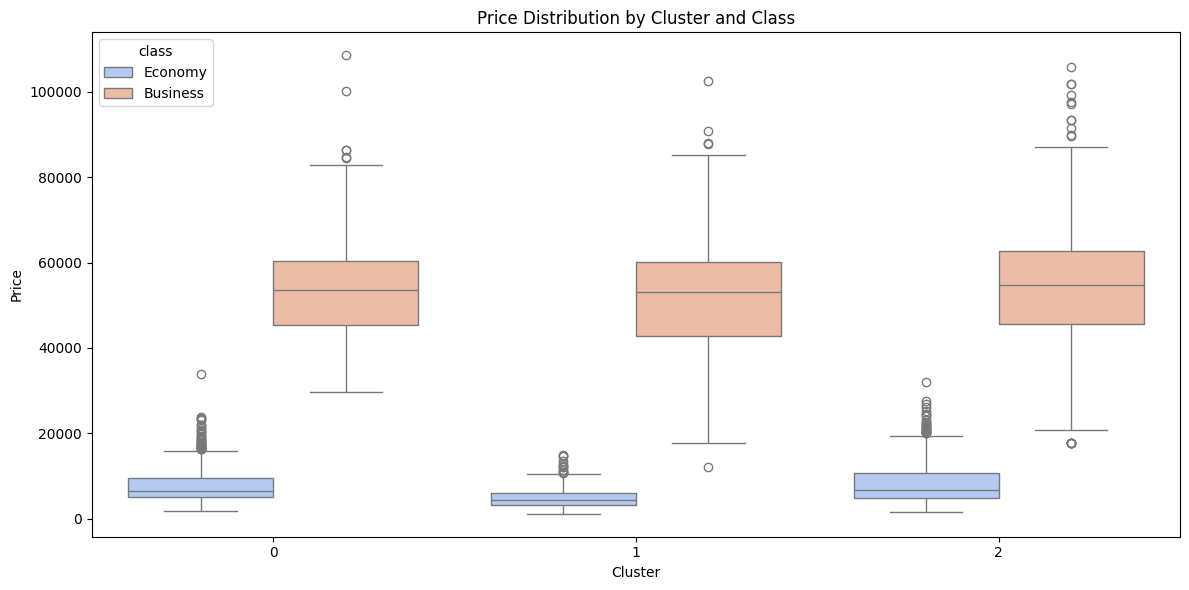


--- Detailed Feature Distribution by Cluster ---


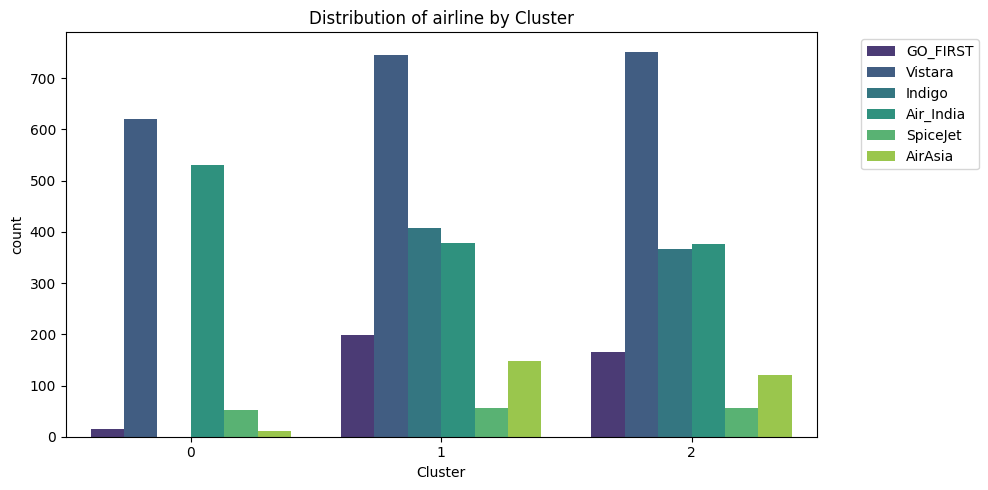

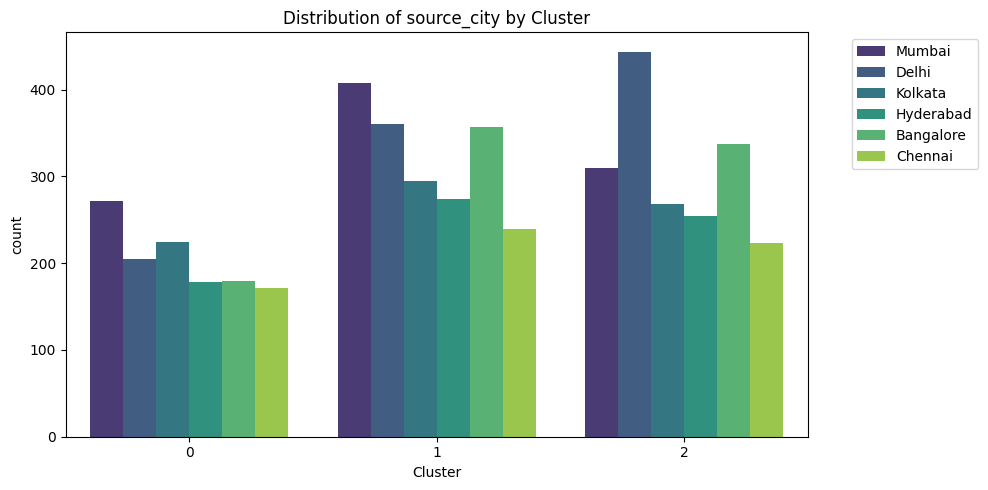

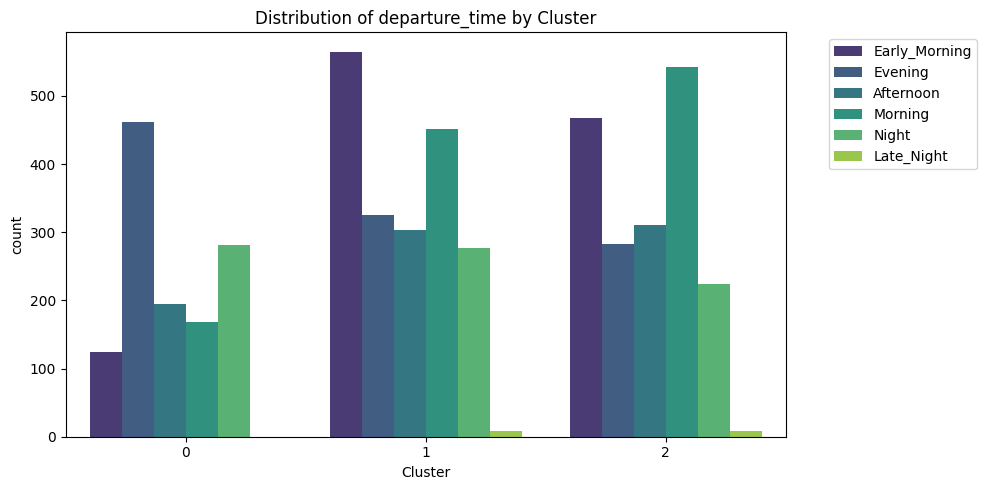

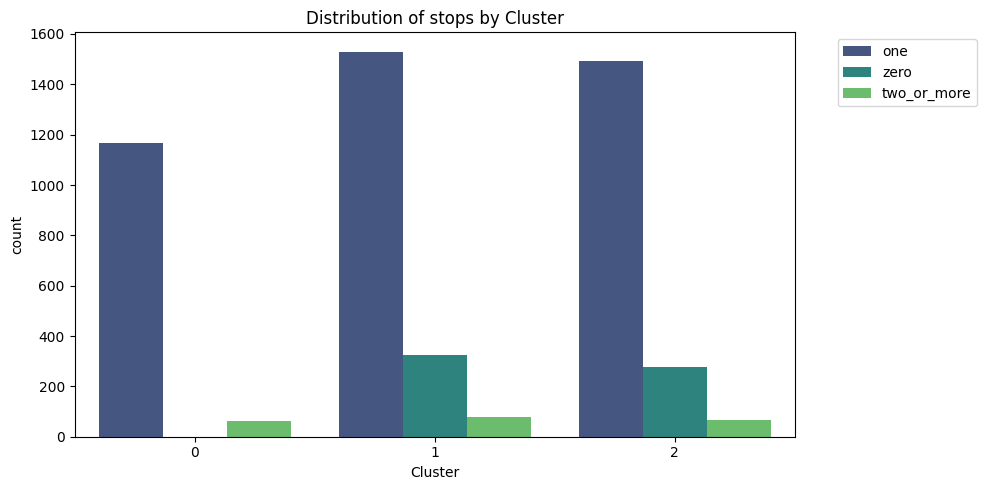

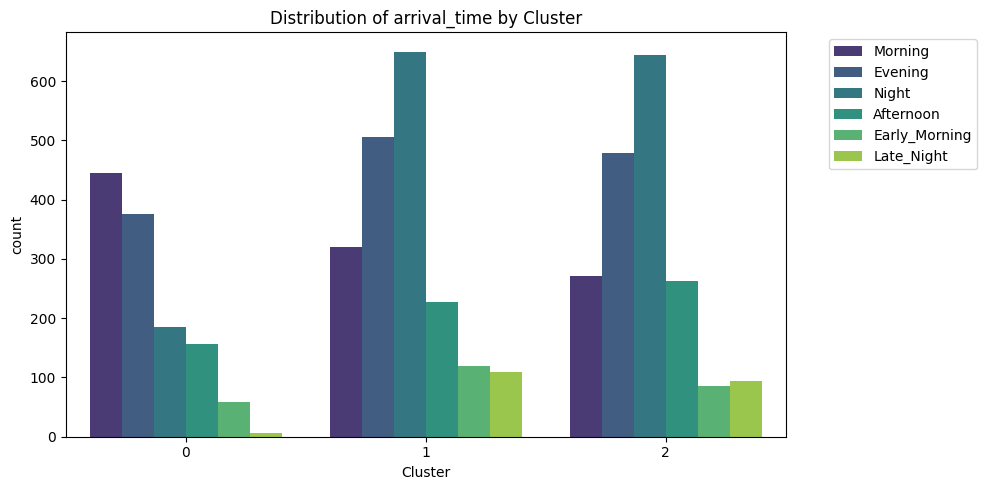

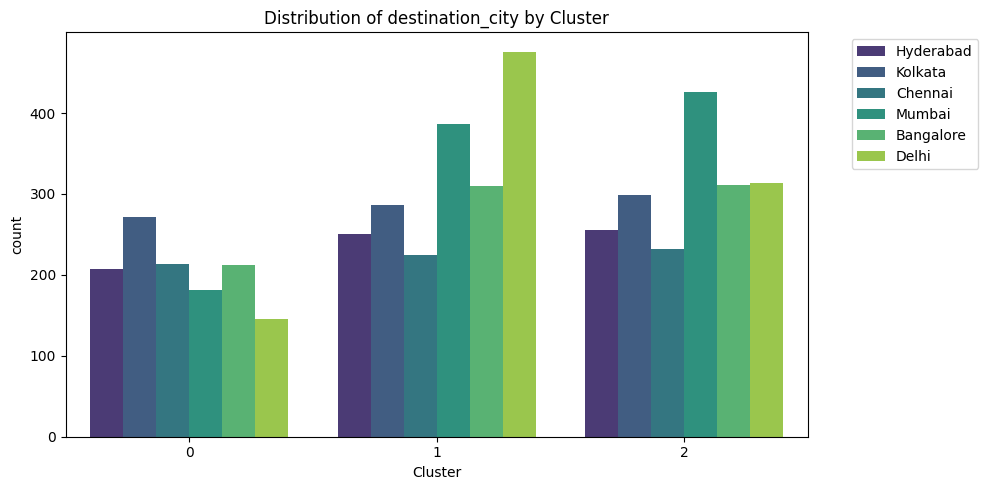

/tmp/ipython-input-157393687.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_subset, x='Cluster', y=col, palette='viridis', order=['0', '1', '2'])


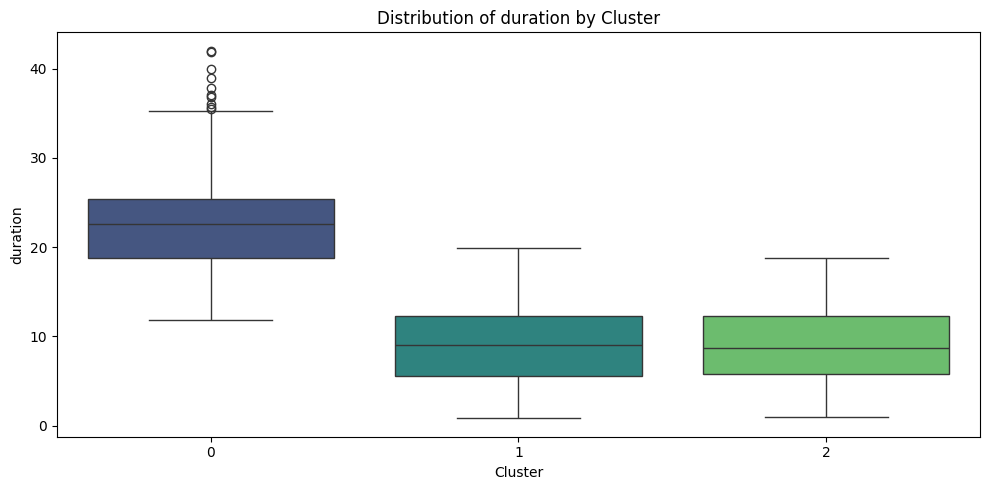

/tmp/ipython-input-157393687.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_subset, x='Cluster', y=col, palette='viridis', order=['0', '1', '2'])


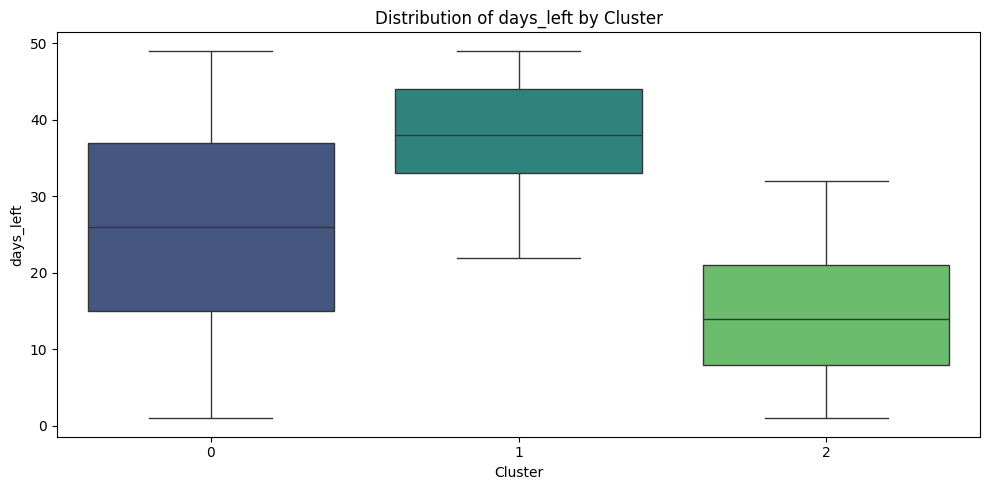

In [ ]:
!pip install kmodes
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
import pandas as pd
import numpy as np

# --- STEP 1: PREPARE DATA ---
# Scale numerical columns, leave categorical columns as is
scaler = StandardScaler()
X_matrix = X.copy()
X_matrix[numerical_cols] = scaler.fit_transform(X_matrix[numerical_cols])

# Get indices of categorical columns
categorical_indices = [X.columns.get_loc(c) for c in categorical_cols]
matrix_input = X_matrix.values

# --- STEP 2: RUN K-PROTOTYPES ---
print("Running K-Prototypes with 3 clusters...")
kproto = KPrototypes(n_clusters=3, init='Cao', verbose=1, random_state=42)
clusters = kproto.fit_predict(matrix_input, categorical=categorical_indices)

# Add clusters to our analysis dataframe
df_subset = df_subset.copy()
df_subset['Cluster'] = clusters.astype(str)

# --- STEP 3: PRICE ANALYSIS (Global & By Class) ---
print("\n--- Price Analysis by Cluster ---")

# Price Distribution by Cluster AND Class (Integrated)
# Note: Ensure the column name 'class' matches your dataframe (e.g., 'class', 'Class', 'cabin_class')
target_class_col = 'class'  # <--- CHANGE THIS if your column name is different

if target_class_col in df_subset.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_subset, x='Cluster', y='price', hue=target_class_col, palette='coolwarm', order=['0', '1', '2']) # Corrected 'Price' to 'price'
    plt.title(f'Price Distribution by Cluster and {target_class_col.capitalize()}')
    plt.xlabel('Cluster')
    plt.ylabel('Price')
    plt.legend(title=target_class_col)
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping Class vs Price plot: Column '{target_class_col}' not found.")

# --- STEP 4: DETAILED FEATURE ANALYSIS ---
features_to_plot = categorical_cols + numerical_cols

print("\n--- Detailed Feature Distribution by Cluster ---")
for col in features_to_plot:
    # Skip Price here since we already plotted it above
    if col == 'price': # Changed from 'Price' to 'price' to reflect the correct column name
        continue

    # Skip the Class column here if you don't want it repeated immediately after the chart above
    if col == target_class_col:
        continue

    plt.figure(figsize=(10, 5))

    if col in categorical_cols:
        # Bar Plot for Categorical
        sns.countplot(data=df_subset, x='Cluster', hue=col, palette='viridis', order=['0', '1', '2'])
        plt.title(f'Distribution of {col} by Cluster')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        # Box Plot for Numerical
        sns.boxplot(data=df_subset, x='Cluster', y=col, palette='viridis', order=['0', '1', '2'])
        plt.title(f'Distribution of {col} by Cluster')

    plt.tight_layout()
    plt.show()

Running FAMD...


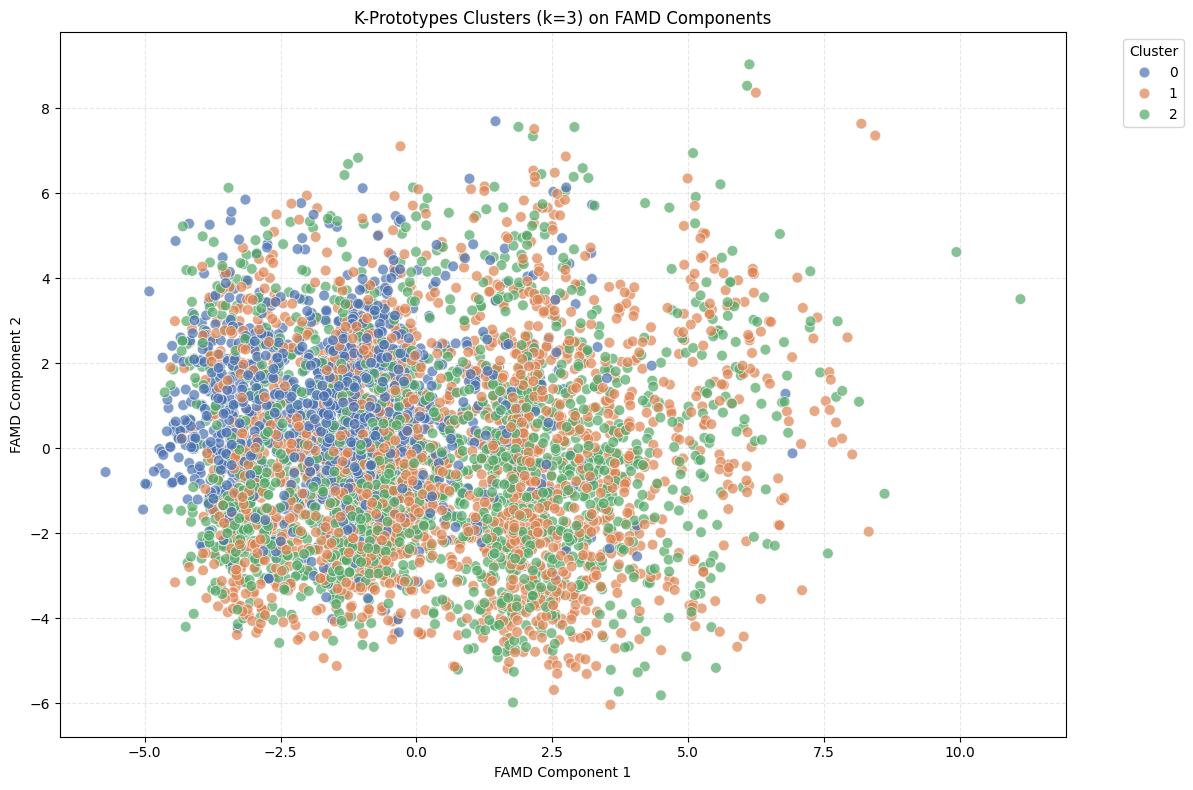

In [ ]:
import prince
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Run FAMD (on X, without Price - assuming X is already prepared)
print("Running FAMD...")
famd = prince.FAMD(
    n_components=2,
    n_iter=3,
    copy=False,
    check_input=True,
    engine='sklearn',
    random_state=42
)

# Fit and Transform
famd_coords = famd.fit_transform(X)

# 2. Add FAMD Coordinates to DataFrame
df_subset['FAMD Component 1'] = famd_coords.iloc[:, 0]
df_subset['FAMD Component 2'] = famd_coords.iloc[:, 1]

# Ensure Cluster column is string type for consistent plotting
df_subset['Cluster'] = df_subset['Cluster'].astype(str)

# 3. Scatter Plot with Enforced Order
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_subset,
    x='FAMD Component 1',
    y='FAMD Component 2',
    hue='Cluster',
    palette='deep',
    hue_order=['0', '1', '2'],  # <--- THIS ENFORCES THE 0, 1, 2 ORDER
    s=60,
    alpha=0.7
)

plt.title('K-Prototypes Clusters (k=3) on FAMD Components')
plt.xlabel('FAMD Component 1')
plt.ylabel('FAMD Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()